In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import warnings
import os
warnings.filterwarnings("ignore")

In [23]:
# Verificar si la carpeta 'imagenes' existe, y si no, crearla
if not os.path.exists('imagenes'):
    os.makedirs('imagenes')

# Información relevante:

Las características se calculan a partir de una imagen digitalizada de una aspiración con aguja fina (AAF) de una masa mamaria. Describen las características de los núcleos celulares presentes en la imagen. El plano de separación descrito anteriormente se obtuvo utilizando el Método de Árbol de Superficie Múltiple (MSM-T) [K. P. Bennett, "Construcción de Árboles de Decisión a través de Programación Lineal." Actas de la 4ª Sociedad del Medio Oeste de Inteligencia Artificial y Ciencia Cognitiva, pp. 97-101, 1992], un método de clasificación que utiliza programación lineal para construir un árbol de decisión. Las características relevantes se seleccionaron mediante una búsqueda exhaustiva en el espacio de 1 a 4 características y 1 a 3 planos de separación. El programa lineal real utilizado para obtener el plano de separación en el espacio tridimensional es el descrito en: [K. P. Bennett y O. L. Mangasarian: "Programación Lineal Robusta para la Discriminación de Dos Conjuntos Linealmente Inseparables", Métodos de Optimización y Software 1, 1992, 23-34].

Número de instancias: 569

Número de atributos: 32 (ID, diagnóstico, 30 características de entrada con valores reales)

Diagnóstico (M = maligno, B = benigno)

Diez características con valores reales se calculan para cada núcleo celular:

a) radio (media de distancias desde el centro hasta puntos en el perímetro)
b) textura (desviación estándar de los valores de escala de grises)
c) perímetro
d) área
e) suavidad (variación local en las longitudes del radio)
f) compacidad (perímetro^2 / área - 1.0)
g) concavidad (gravedad de las porciones cóncavas del contorno)
h) puntos cóncavos (número de porciones cóncavas del contorno)
i) simetría
j) dimensión fractal ("aproximación de la línea costera" - 1)

Valores faltantes de atributos: ninguno

Distribución de clases: 357 benignos, 212 malignos

Creadores:

Dr. William H. Wolberg, Departamento de Cirugía General, Universidad de Wisconsin.

W. Nick Street, Departamento de Ciencias de la Computación, Universidad de Wisconsin.

Olvi L. Mangasarian, Departamento de Ciencias de la Computación, Universidad de Wisconsin.

In [11]:
# Leer el archivo CSV
df = pd.read_csv('breast-cancer-wisconsin.csv')

## Mostrar las primeras filas del DataFrame

In [12]:
# Mostrar las primeras filas del DataFrame
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Mostrar las columnas del DataFrame

In [4]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

## Resumen conciso del DataFrame

In [13]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Proporcionando una visión clínica sobre las estadísticas del conjunto de datos

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


## Eliminando columnas innecesarias con una precisión clínica.

In [16]:
df.drop(columns=["id", "Unnamed: 32"], inplace=True)

## Distribución Clínica de Diagnósticos Benignos y Malignos


Perspectiva Clínica: Proclamación de Porcentajes de Pacientes
Porcentaje de Diagnósticos Benignos: 63%
Porcentaje de Diagnósticos Malignos: 37%


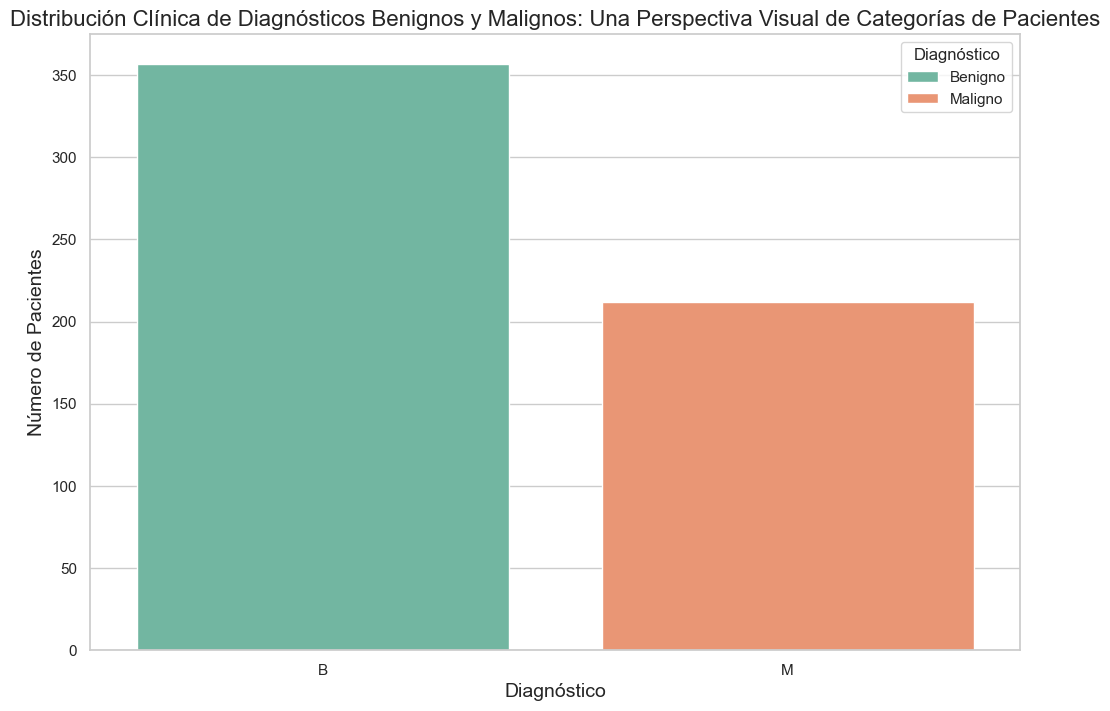

In [24]:
plt.figure(figsize=(12, 8))  # Ajusta el tamaño según sea necesario
sns.set(style="whitegrid")

# Revelando la distribución de diagnósticos benignos y malignos
benign_or_malignant = df["diagnosis"].value_counts()
barplot = sns.barplot(x=benign_or_malignant.index, y=benign_or_malignant.values, hue=["Benigno", "Maligno"], palette=["#66c2a5", "#fc8d62"])

# Agregando un toque de elegancia clínica al gráfico
plt.title("Distribución Clínica de Diagnósticos Benignos y Malignos: Una Perspectiva Visual de Categorías de Pacientes", fontsize=16)
plt.xlabel("Diagnóstico", fontsize=14)
plt.ylabel("Número de Pacientes", fontsize=14)
plt.legend(title="Diagnóstico")

# Mostrando la proclamación clínica de porcentajes
print("\nPerspectiva Clínica: Proclamación de Porcentajes de Pacientes")
print(f"Porcentaje de Diagnósticos Benignos: {benign_or_malignant[0] / sum(benign_or_malignant.values) * 100:.0f}%")
print(f"Porcentaje de Diagnósticos Malignos: {benign_or_malignant[1] / sum(benign_or_malignant.values) * 100:.0f}%")

# Guardar la imagen en la carpeta 'imagenes' con el nombre 'maligno_vs_benignos.png'
plt.savefig('imagenes/maligno_vs_benignos.png')

# Mostrando el gran final clínico
plt.show()

## Correlaciones de las Características Médicas

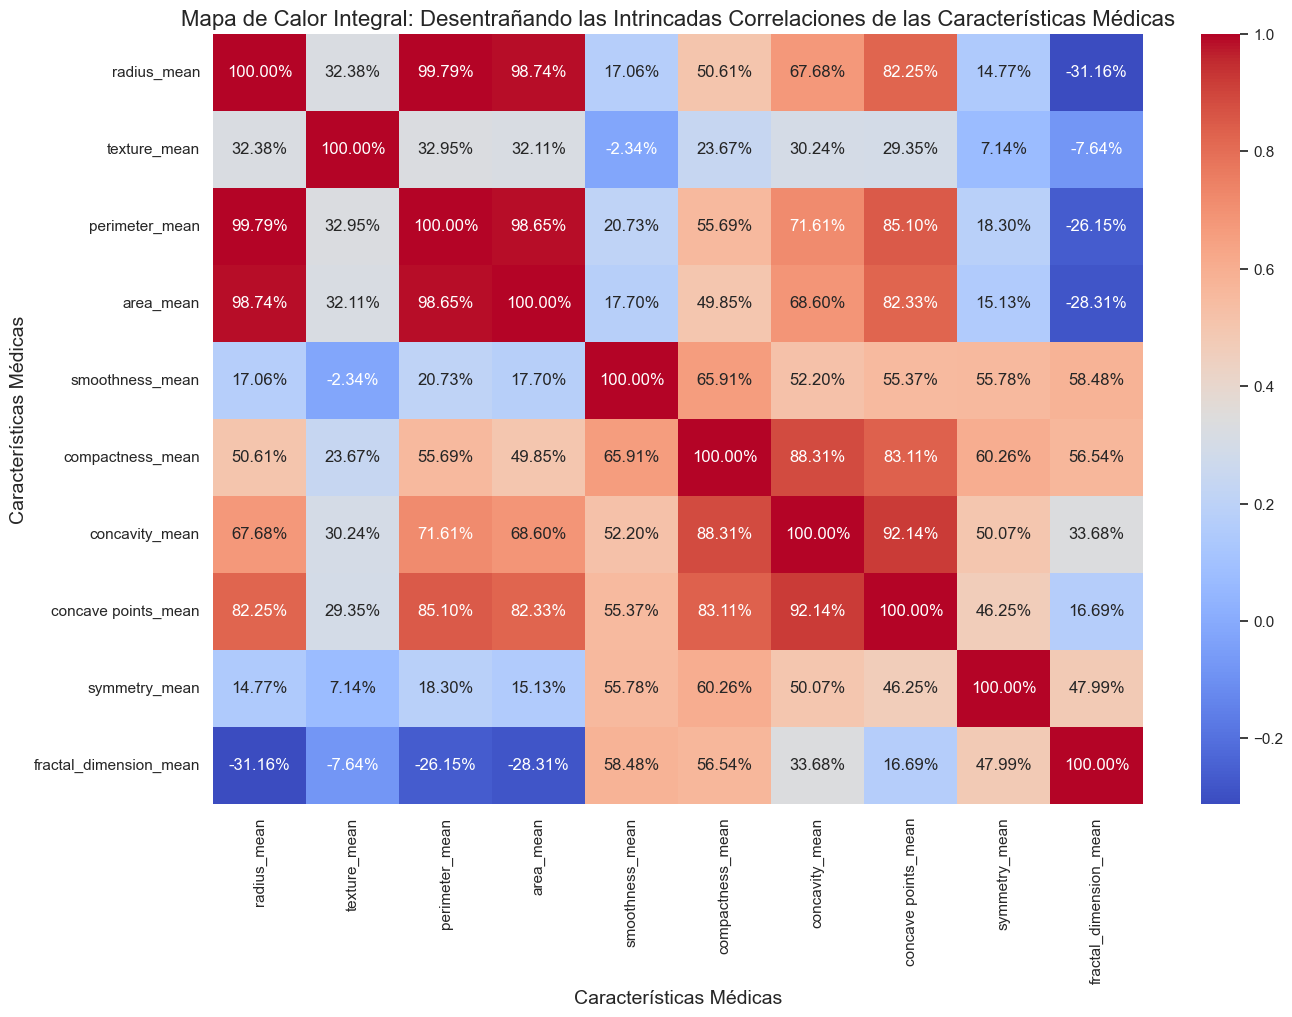

In [31]:
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Revelando las intrincadas correlaciones entre las características médicas
correlation_matrix = df.iloc[:, 1:11].corr()
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2%", cmap="coolwarm")

# Agregando un toque de significancia clínica al gráfico
plt.title("Mapa de Calor Integral: Desentrañando las Intrincadas Correlaciones de las Características Médicas", fontsize=16)
plt.xlabel("Características Médicas", fontsize=14)
plt.ylabel("Características Médicas", fontsize=14)

# Guardar la imagen en la carpeta 'imagenes'
plt.savefig('imagenes/correlacion_variables.png')
# Mostrando el mapa de calor perspicaz
plt.show()

## Construir los modelos con PCA

In [29]:
shuffled_data = df.sample(frac=1,random_state=42)
features = shuffled_data.drop(columns=["diagnosis"])
target = shuffled_data["diagnosis"]
print(features.shape,target.shape,sep="\n")

(569, 30)
(569,)


In [30]:
# Imprimir el número de columnas antes de PCA
print(f"Datos Antes de PCA: {features.shape[1]}")
# Aplicar PCA con 0.999 de varianza
pca = PCA(0.999)
pca.fit(features)
features_PCA = pca.transform(features)
# Crear un DataFrame con los componentes PCA
pca_columns = [f'PCA{i}' for i in range(1, features_PCA.shape[1] + 1)]
features_PCA_df = pd.DataFrame(data=features_PCA, columns=pca_columns)
# Imprimir el número de columnas después de PCA
print(f"Datos Después de PCA: {features_PCA_df.shape[1]}")
# Mostrar el nuevo DataFrame
print(features_PCA_df.head())

Datos Antes de PCA: 30
Datos Después de PCA: 3
          PCA1        PCA2      PCA3
0  -263.623436  -42.768553  4.720700
1  1092.401048 -105.035759 -4.628682
2   284.948132  -62.392015 -7.948702
3  -410.186841   29.410370 -2.577956
4  -493.647933    3.930971  8.498568


## Determinación del Número Óptimo de Componentes Principales

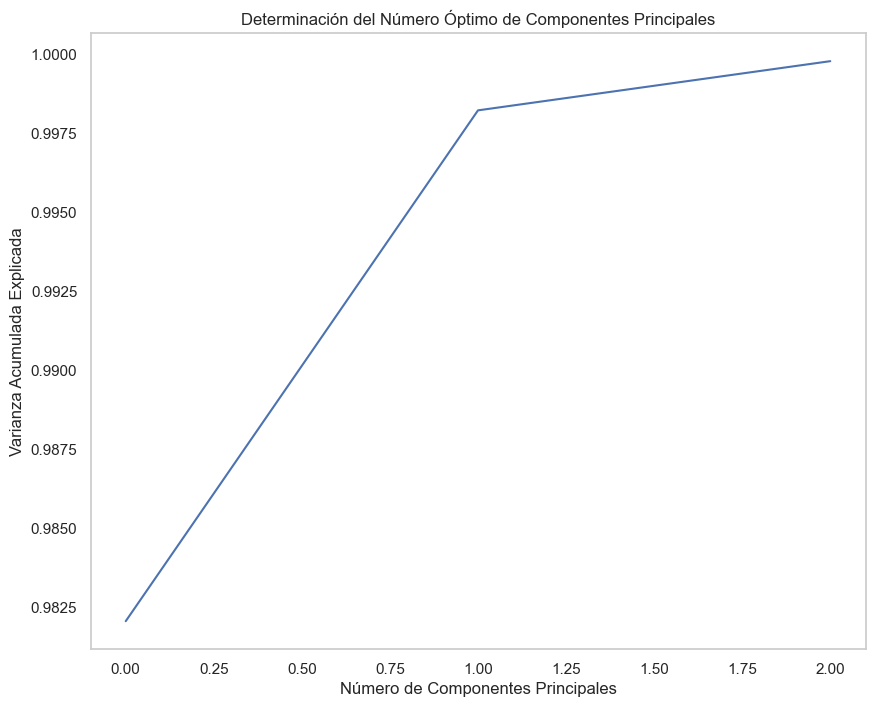

In [32]:
plt.figure(figsize=(10, 8))
plt.xlabel("Número de Componentes Principales")
plt.ylabel("Varianza Acumulada Explicada")
plt.title("Determinación del Número Óptimo de Componentes Principales")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
# Guardar la imagen en la carpeta 'imagenes'
plt.savefig('imagenes/pca_numero_ideal.png')
plt.show()

## Separar datos de pruebas y de entrenamiento

In [33]:
X_train,X_test,y_train,y_test = train_test_split(features_PCA_df,target,test_size=0.2,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape,sep="\n")

(455, 3)
(114, 3)
(455,)
(114,)


In [34]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [35]:
def Model(X_train, y_train):
    # 1- Logistic Regression
    LR = LogisticRegression(max_iter=1000, random_state=1)
    LR_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    LR_grid = GridSearchCV(LR, LR_params, cv=5)
    LR_grid.fit(X_train, y_train)
    best_LR_model = LR_grid.best_estimator_

    # 2- SVM
    SVM = SVC(random_state=7)
    SVM_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    SVM_grid = GridSearchCV(SVM, SVM_params, cv=5)
    SVM_grid.fit(X_train, y_train)
    best_SVM_model = SVM_grid.best_estimator_

    # 3- Decision Tree
    Tree = DecisionTreeClassifier(random_state=7, criterion="entropy")
    Tree_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}
    Tree_grid = GridSearchCV(Tree, Tree_params, cv=5)
    Tree_grid.fit(X_train, y_train)
    best_Tree_model = Tree_grid.best_estimator_

    # 4- Random Forest Classifier
    RFC = RandomForestClassifier(random_state=7, criterion="entropy")
    RFC_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
    RFC_grid = GridSearchCV(RFC, RFC_params, cv=5)
    RFC_grid.fit(X_train, y_train)
    best_RFC_model = RFC_grid.best_estimator_

    # Print scores and best parameters for all models
    print(f"Score of Logistic Regression is {LR_grid.score(X_train, y_train):0.2%} and best parameters were \'{best_LR_model}\'")
    print(f"Score of SVM is {SVM_grid.score(X_train, y_train):0.2%} and best parameters were \'{best_SVM_model}\'")
    print(f"Score of Decision Tree is {Tree_grid.score(X_train, y_train):0.2%} and best parameters were \'{best_Tree_model}\'")
    print(f"Score of Random Forest Classifier is {RFC_grid.score(X_train, y_train):0.2%} and best parameters were \'{best_RFC_model}\'")

    return best_LR_model, best_SVM_model, best_Tree_model, best_RFC_model

In [36]:
final_LR_model, final_SVM_model, final_Tree_model, final_RFC_model = Model(X_train, y_train)

Score of Logistic Regression is 94.29% and best parameters were 'LogisticRegression(C=100, max_iter=1000, random_state=1)'
Score of SVM is 94.51% and best parameters were 'SVC(C=1, random_state=7)'
Score of Decision Tree is 100.00% and best parameters were 'DecisionTreeClassifier(criterion='entropy', random_state=7)'
Score of Random Forest Classifier is 100.00% and best parameters were 'RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=7)'


In [37]:
def Test_Results(LR, SVM, TRE, RFC, X_test, y_test):
    # 1. LR Model Test Score
    Score_Of_LR = LR.score(X_test, y_test)
    print(f"LR Model Test Score: {Score_Of_LR:0.2%}")

    # 2. SVM Model Test Score
    Score_Of_SVM = SVM.score(X_test, y_test)
    print(f"SVM Model Test Score: {Score_Of_SVM:0.2%}")

    # 3. Decision Tree Model Test Score
    Score_Of_DT = TRE.score(X_test, y_test)
    print(f"Decision Tree Model Test Score: {Score_Of_DT:0.2%}")

    # 4. Random Forest Classifier Model Test Score
    Score_Of_RFC = RFC.score(X_test, y_test)
    print(f"Random Forest Classifier Model Test Score: {Score_Of_RFC:0.2%}")

In [38]:
Test_Results(final_LR_model, final_SVM_model, final_Tree_model, final_RFC_model,X_test,y_test)

LR Model Test Score: 92.11%
SVM Model Test Score: 88.60%
Decision Tree Model Test Score: 89.47%
Random Forest Classifier Model Test Score: 91.23%


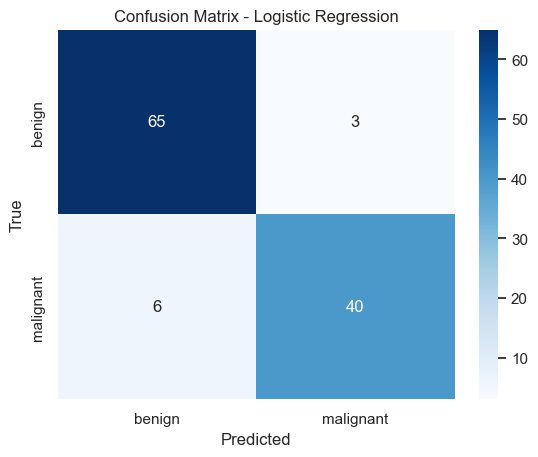

              precision    recall  f1-score   support

           B       0.92      0.96      0.94        68
           M       0.93      0.87      0.90        46

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.92       114
weighted avg       0.92      0.92      0.92       114



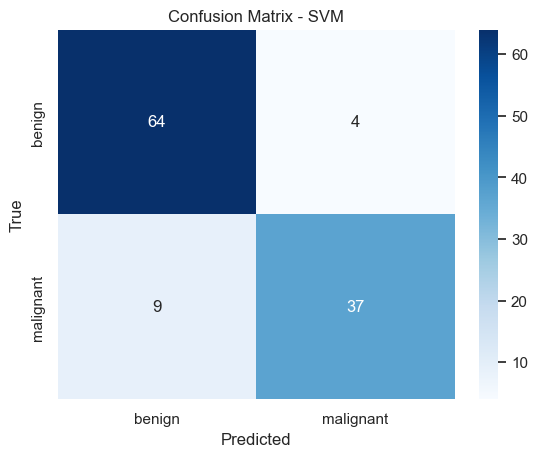

              precision    recall  f1-score   support

           B       0.88      0.94      0.91        68
           M       0.90      0.80      0.85        46

    accuracy                           0.89       114
   macro avg       0.89      0.87      0.88       114
weighted avg       0.89      0.89      0.88       114



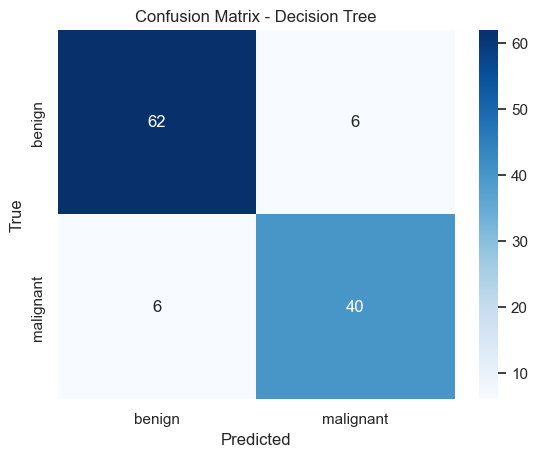

              precision    recall  f1-score   support

           B       0.91      0.91      0.91        68
           M       0.87      0.87      0.87        46

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg       0.89      0.89      0.89       114



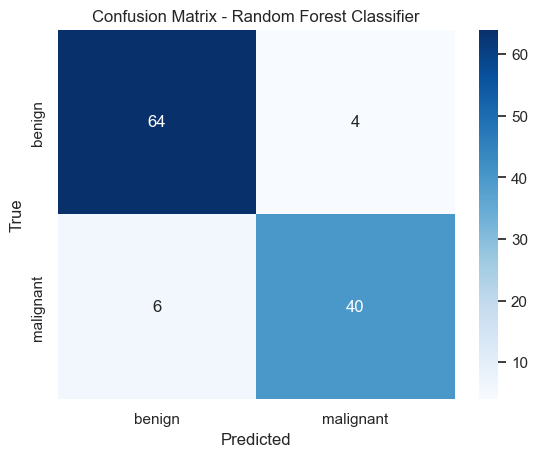

              precision    recall  f1-score   support

           B       0.91      0.94      0.93        68
           M       0.91      0.87      0.89        46

    accuracy                           0.91       114
   macro avg       0.91      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114



In [40]:
def Classification_Draw(models, X_test, y_test):
    # Define class names
    class_names = ['benign', 'malignant']

    for model, model_name in models:
        # Calculate the confusion matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True,cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {model_name}')
        # Guardar la imagen en la carpeta 'imagenes'
        plt.savefig(f'imagenes/Confusion Matrix - {model_name}.png')
        plt.show()
        print(classification_report(y_test,y_pred))

# Assuming you have a list of models and their names
models = [(final_LR_model, 'Logistic Regression'),
          (final_SVM_model, 'SVM'),
          (final_Tree_model, 'Decision Tree'),
          (final_RFC_model, 'Random Forest Classifier')]

# Call the function to generate confusion matrix plots
Classification_Draw(models, X_test, y_test)